In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [3]:
img1=cv2.imread('input_data/a1.png')
img2=cv2.imread('input_data/a2.png')

In [4]:
counter = 0

#Replace K with given Intrinsic Matrix
K = np.array([[518.86, 0., 285.58],
              [0., 519.47, 213.74],
              [0.,   0.,   1.]])

In [5]:
#SIFT feature matching
#detect sift features for both images
sift = cv2.xfeatures2d.SIFT_create()
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)

In [6]:
#use flann to perform feature matching
FLANN_INDEX_KDTREE = 0        #FLANN (Fast Library for Approximate Nearest Neighbors)
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)   
search_params = dict(checks = 50)  #50 iterations to search for the best match
flann = cv2.FlannBasedMatcher(index_params, search_params) 
matches = flann.knnMatch(des1,des2,k=2)  #2-nearest neighbour for each descriptor

To filter the matches, Lowe proposed to use a distance ratio test to try to eliminate false matches. The distance ratio between the two nearest matches of a considered keypoint is computed and it is a good match when this value is below a threshold.
https://docs.opencv.org/3.4/d5/d6f/tutorial_feature_flann_matcher.html

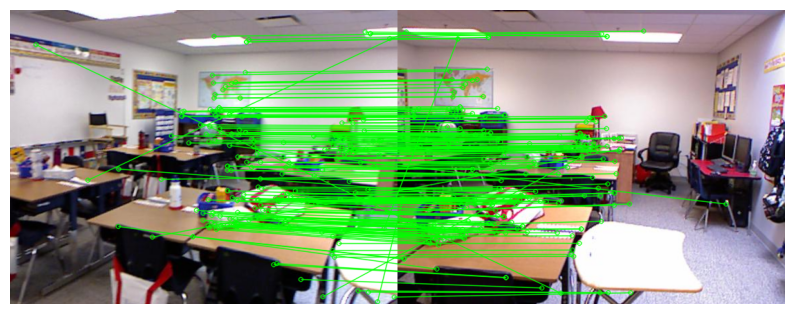

In [9]:
# store all the good matches as per Lowe's ratio test.
good = []     # matches that pass the Lowe's test
for m,n in matches:
    if m.distance < 0.7*n.distance:
        good.append(m)

MIN_MATCH_COUNT = 3   #minimum number of matches required to find the object (More the better)

if len(good)>MIN_MATCH_COUNT:
    p1 = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)   #get the keypoints corresponding to the each good match for Image1
    p2 = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)   #for Image 2

draw_params = dict(matchColor = (0,255,0), singlePointColor = None, flags = 2)
img_siftmatch = cv2.drawMatches(img1,kp1,img2,kp2,good,None,**draw_params)
# Convert the image from OpenCV's BGR format to RGB for displaying in matplotlib
img_siftmatch_rgb = cv2.cvtColor(img_siftmatch, cv2.COLOR_BGR2RGB)
# Display the image in the output cell
plt.figure(figsize=(10, 10))
plt.imshow(img_siftmatch_rgb)
plt.axis('off')  # Turn off axis numbers
plt.show()

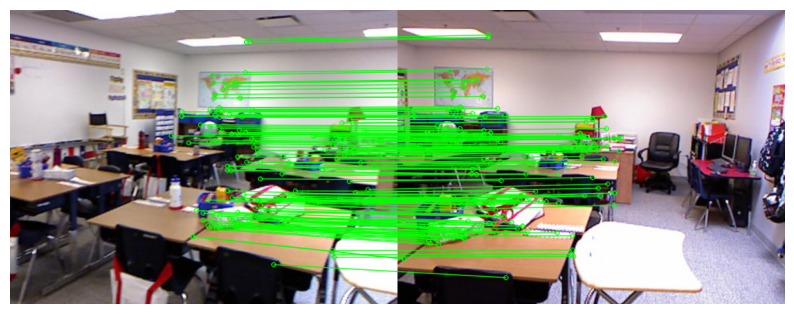

In [10]:
#essential matrix
#Ransac is used to estimate the essential matrix by fitting keypoints in the model
#mask is used to filter out the outliers (0 then it is outlier, 1 then it is inlier)
E, mask = cv2.findEssentialMat(p1, p2, K, cv2.RANSAC, 0.999, 1.0);    #confidence level=0.999, threshold=1.0 (Greater the threshold, lesser the outliers)
matchesMask = mask.ravel().tolist()
draw_params = dict(matchColor = (0,255,0), singlePointColor = None,matchesMask = matchesMask,flags = 2)
img_inliermatch = cv2.drawMatches(img1,kp1,img2,kp2,good,None,**draw_params)
# Convert the image from OpenCV's BGR format to RGB for displaying in matplotlib
img_inliermatch_rgb = cv2.cvtColor(img_inliermatch, cv2.COLOR_BGR2RGB)
# Display the image in the output cell
plt.figure(figsize=(10, 10))
plt.imshow(img_inliermatch_rgb)
plt.axis('off')  # Turn off axis numbers
plt.show()

In [11]:
print("Essential matrix:")
print(E)

Essential matrix:
[[ 0.03529077 -0.64288908  0.00592328]
 [ 0.49342169  0.02861084 -0.50550124]
 [-0.02644593  0.29126419  0.00799014]]


In [13]:
#recoverpose
#recoverpose is used to estimate the rotation and translation matrix
#points are the keypoints in the image and mask is the inlier mask
#cv2.recoverPose() uses SVD to decompose E into R and t and calculates the correct pose by reducing reprojection error
points, R, t, mask = cv2.recoverPose(E, p1, p2)
print("Rotation:")
print(R)
print("Translation:")
print(t)
p1_tmp = np.ones([3, p1.shape[0]])
p1_tmp[:2,:] = np.squeeze(p1).T
p2_tmp = np.ones([3, p2.shape[0]])
p2_tmp[:2,:] = np.squeeze(p2).T
#Print the difference between transformed points and original points
print((np.dot(R, p2_tmp) + t) - p1_tmp)

Rotation:
[[ 0.93091648  0.04776557 -0.36209524]
 [-0.04717009  0.99883179  0.01048993]
 [ 0.36217329  0.00731482  0.93208208]]
Translation:
[[-0.41331127]
 [-0.01923294]
 [-0.91038667]]
[[ 2.01094466e+02 -1.00079780e+02 -8.64152128e+01  7.58630265e+01
   1.02391540e+02  8.60381045e+01 -2.17275428e+02 -2.19148081e+02
  -2.19497370e+02 -2.20954444e+02 -2.16717600e+02 -2.19675816e+02
  -2.39285126e+02 -2.39285126e+02 -2.31986455e+02 -2.14732963e+02
  -2.31371969e+02 -2.30190300e+02 -2.12959865e+02 -2.29144389e+02
  -2.30760861e+02 -2.10340058e+02 -2.28887066e+02 -2.14436388e+02
  -2.14191613e+02 -2.28607358e+02 -2.29520048e+02 -2.18574216e+02
  -2.30210198e+02 -2.12923360e+02 -2.16655234e+02  3.70079857e+01
  -2.15273721e+02 -2.28014743e+02 -2.08083053e+02 -2.15096329e+02
  -2.12147462e+02 -2.27875426e+02 -2.13017645e+02 -2.11477986e+02
  -2.12049469e+02 -2.12049469e+02 -2.11325397e+02 -2.10403481e+02
  -2.28982629e+02 -2.27218646e+02 -2.09231012e+02 -2.12360181e+02
  -2.15080829e+02 -2.

In [14]:
#triangulation
#calculate projection matrix for both camera
M_r = np.hstack((R, t))    #for right camera, Stack R and t horizontally to form the extrinsic matrix, dimension = 3 X 4
M_l = np.hstack((np.eye(3, 3), np.zeros((3, 1))))   #Taking extrinsic matrix for left camera as identiy matrix, dimension = 3 X 1
#In Stereo Vision, Left Camera is usually taken as reference camera
P_l = np.dot(K,  M_l)    #projection matrix for left camera by taking dot of intrinsic matrix and projection matrix
P_r = np.dot(K,  M_r)    #projection matrix for right camera by taking dot of intrinsic matrix and projection matrix

# undistort points is to correct the distortion by the camera's lens. They can introduce distortion, particularly radial distortion, which causes straight lines to appear curved.
p1 = p1[np.asarray(matchesMask)==1,:,:]    #keep only inliers
p2 = p2[np.asarray(matchesMask)==1,:,:]
p1_un = cv2.undistortPoints(p1,K,None)     #undistort the points using the intrinsic matrix 
p2_un = cv2.undistortPoints(p2,K,None)
p1_un = np.squeeze(p1_un)     #remove the extra dimension
p2_un = np.squeeze(p2_un)

#triangulate points this requires points in normalized coordinate
point_4d_hom = cv2.triangulatePoints(P_l, P_r, p1_un.T, p2_un.T)
point_3d = point_4d_hom / np.tile(point_4d_hom[-1, :], (4, 1))  #normalize the 4D points by dividing by the last element
point_3d = point_3d[:3, :].T

In [19]:
point_3d

array([[ 1.0800127 ,  0.9588359 , -2.0272005 ],
       [ 1.0799102 ,  0.9591103 , -2.0272563 ],
       [ 1.0799112 ,  0.9591124 , -2.0272632 ],
       [ 1.0799246 ,  0.959182  , -2.0272992 ],
       [ 1.0798248 ,  0.95875734, -2.0272038 ],
       [ 1.0799425 ,  0.95755565, -2.0273108 ],
       [ 1.0799425 ,  0.95755565, -2.0273108 ],
       [ 1.0798404 ,  0.9579028 , -2.0272577 ],
       [ 1.0796356 ,  0.9589642 , -2.0271287 ],
       [ 1.0797577 ,  0.95787627, -2.0272436 ],
       [ 1.0797416 ,  0.9577656 , -2.0272012 ],
       [ 1.0795492 ,  0.958834  , -2.027075  ],
       [ 1.0796708 ,  0.9576845 , -2.027164  ],
       [ 1.0796926 ,  0.9580635 , -2.0272605 ],
       [ 1.0794874 ,  0.9587161 , -2.0270095 ],
       [ 1.0796546 ,  0.95765966, -2.0271552 ],
       [ 1.0795228 ,  0.95894676, -2.0271144 ],
       [ 1.0795157 ,  0.95916605, -2.027134  ],
       [ 1.0796251 ,  0.9577284 , -2.027157  ],
       [ 1.0796337 ,  0.95783967, -2.0271966 ],
       [ 1.0795398 ,  0.9596508 , -2.027

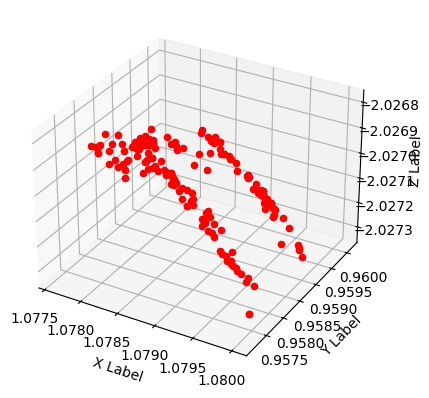

In [15]:
#Display 3D points
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
for x, y, z in point_3d:
    ax.scatter(x, y, z, c="r", marker="o")
plt.show()

In [18]:
# Save 3D points as OBJ file
with open('3D_Object'+ '.obj', 'w') as f:
    for x, y, z in point_3d:
        f.write(f"v {x} {y} {z}\n")
fig.savefig('3D_Plot'+ '.jpg')